**Exploratory analysis of the dataset.**

We are interested in identifying factors associated with user ratings of board games. The dataset contains the following variables of interest:

- Release Year
- Weight
- Owners
- Registration Year

The hypothesis is thus that a user's rating for a given board game is correlated with the game's release year, weight, and total owners as well as the user's registration year. We will set $\alpha$ = 0.05 and use the Bonferonni correction for multiple hypothesis testing, giving a threshold of significance $\rho$ = 0.0125.

In [193]:
# import required libraries
import pickle as pickle
import math as math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.api as sm

# change notebook figure sizes
plt.rcParams['figure.figsize'] = [10, 7]

# load the dataset
with open("Objects/20181120_sample_pickle", "rb") as file:
    bgg_data = pickle.load(file)
    
# cast the dataset's columns into the appropriate type
bgg_data[["Rating", "Weight", "Average Rating"]] = bgg_data[["Rating", "Weight", "Average Rating"]].astype(float)
bgg_data[["ID", "Rating Number", "Release Year", "Owners", "Registration Year"]] = bgg_data[["ID", "Rating Number", "Release Year", "Owners", "Registration Year"]].astype(int)

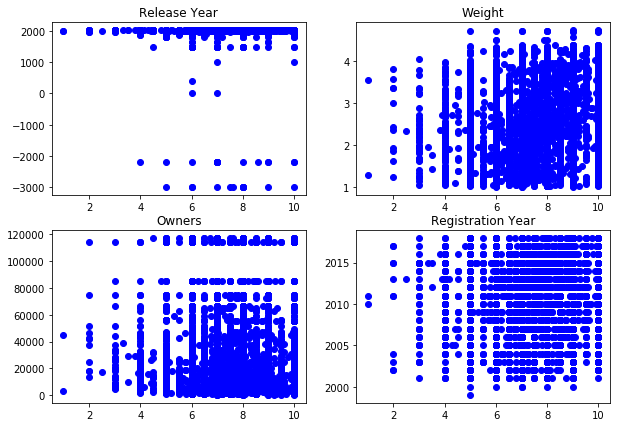

In [11]:
## generate scatterplots of the four variables of interest versus rating
# breakout the needed columns from the larger dataset
to_plot = bgg_data[["Release Year", "Weight", "Owners", "Registration Year"]]

# initialize a plot
plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the plot's position in a 2 x 2 grid
    plt.subplot(2, 2, i + 1)
    
    # plot the column versus rating
    plt.plot(bgg_data["Rating"], to_plot[to_plot.columns[i]], 'bo')
    dd
    # title subplot by column name
    plt.title(to_plot.columns[i])
    
plt.show()

We immediately see a couple of issues to address.

First, there are a number of dramatic release year outliers. We might reasonably assume that user ratings for ancient games such as Chess or Go are driven by different factors than user ratings for games released in the "modern" board game era (~1990 to present). To this end, removing these observations from the dataset and reframing our hypotheses to cover just the modern era is a reasonable approach.

Second, the clear "bar" pattern along the rating axis indicates that the user ratings are perhaps closer to ordinal than continuous. Indeed, when we look at the distribution of user ratings, we find that the vast majority of ratings fall directly on an integer value. We have several options to address this. Most directly, we could round the observed user ratings to the nearest integer value proceed as if it is true ordinal data. Alternatively, we can further alter our hypothesis from considering raw user rating to considering the difference between user rating and the average rating for the given game, the distribution of which is closer to Guassian. I like the second approach better, as it has the secondary benefit of correcting for the innate "quality" of the game.

Implementing these changes, our hypothesis is now:
For board games released after 1990, the difference between a user's rating for a board game and the game's average rating is correlated with the game's release year, weight, and total owners as well as the user's registration year.

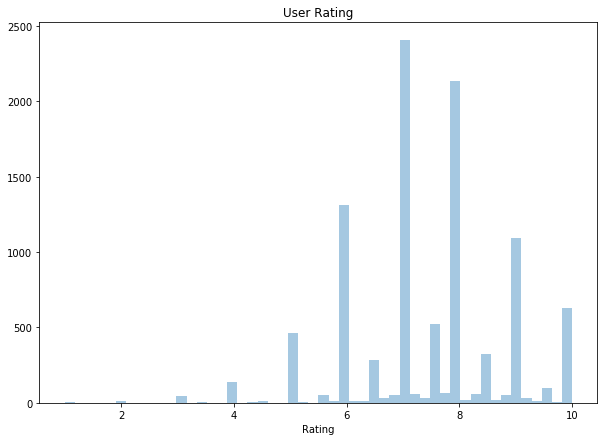

In [12]:
# plot a histogram of the ratings
sns.distplot(bgg_data["Rating"].astype(float), kde = False)
plt.title("User Rating")
plt.show()

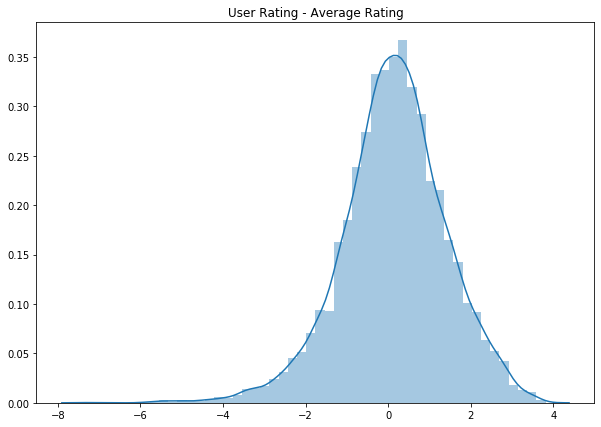

In [13]:
# plot a histogram of user rating - average rating
sns.distplot(bgg_data["Rating"] - bgg_data["Average Rating"])
plt.title("User Rating - Average Rating")
plt.show()

In [96]:
## implementing the changes proposed above
# remove observations with games released prior to 1990 from the dataset
bgg_1990 = bgg_data[bgg_data["Release Year"] >= 1990]

# create a column containing the difference in user and average rating
bgg_1990["Delta Rating"] = bgg_data["Rating"] - bgg_data["Average Rating"]

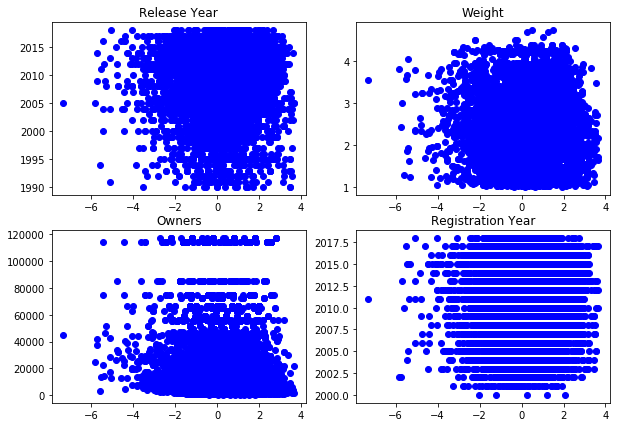

In [15]:
## generate new scatterplots as above with the modified dataset
## now plotting delta rating versus the four variables of interest
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Release Year", "Weight", "Owners", "Registration Year"]]

# initialize a plot
plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the subplot's position in a 2 x 2 grid
    plt.subplot(2, 2, i + 1)
    
    # plot the column versus rating
    plt.plot(bgg_1990["Delta Rating"], to_plot[to_plot.columns[i]], 'bo')
    
    # title subplot by column name
    plt.title(to_plot.columns[i])
    
plt.show()

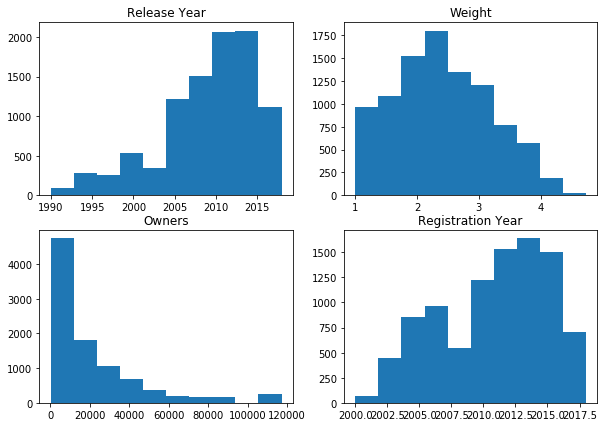

In [16]:
## plot distributions for the four non-rating variables
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Release Year", "Weight", "Owners", "Registration Year"]]

# initialize a plot
plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the subplot's position in a 2 x 2 grid
    plt.subplot(2, 2, i + 1)
    
    # plot the column versus rating
    plt.hist(to_plot[to_plot.columns[i]])
    
    # title subplot by column name
    plt.title(to_plot.columns[i])
    
plt.show()

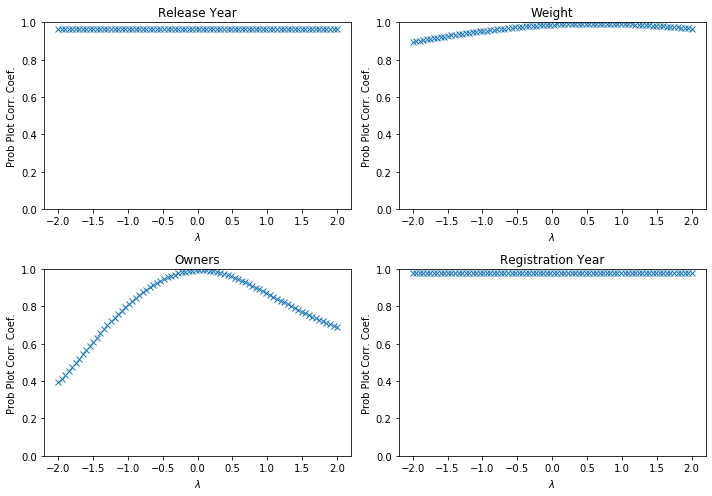

In [194]:
## Box-Cox plots 
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Release Year", "Weight", "Owners", "Registration Year"]]

# initialize a plot
fig = plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the subplot's location in a 2 x 2 grid
    ax = fig.add_subplot(2, 2, i + 1)
    
    # add a Box-Cox plot for the variable
    stats.boxcox_normplot(to_plot[to_plot.columns[i]], -2, 2, plot = ax)
    
    # fix the y-axis across plots
    plt.ylim(0, 1)
    
    # title the subplot with the variable name
    plt.title(to_plot.columns[i])

plt.tight_layout()

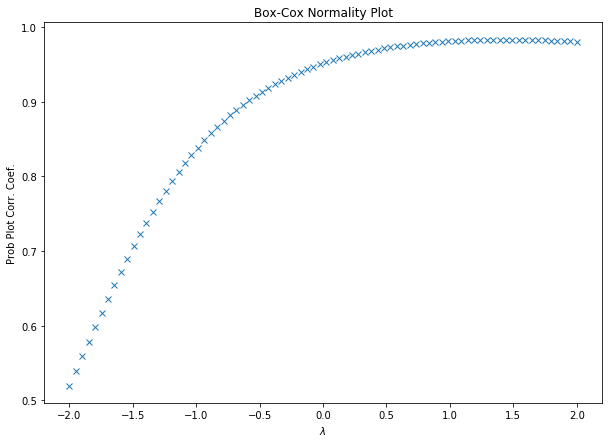

In [202]:
# Box-Cox plot of Ratings
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

stats.boxcox_normplot(bgg_1990["Rating"], -2, 2, plot = ax)

plt.show()

We will log tranform Owners, the remaining variables look normal enough.

We will transform Release Year and Registration Year from the actual year number into years since 1990 (start of dataset) and years since 2000 (start of BGG) to place the coefficients on a more reasonable scale.

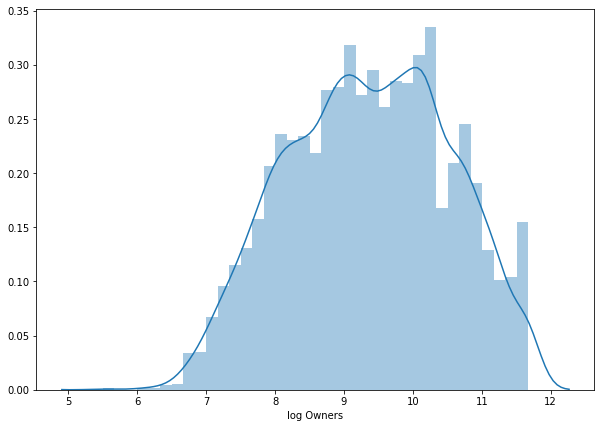

In [97]:
# log transform Owners
bgg_1990["log Owners"] = bgg_1990["Owners"].apply(math.log)

# plot a histogram of Owners
sns.distplot(bgg_1990["log Owners"])
plt.show()

# transform years
bgg_1990["Delta Release"] = bgg_1990["Release Year"].apply(lambda x: x - 1990)
bgg_1990["Delta Registration"] = bgg_1990["Registration Year"].apply(lambda x: x - 2000)

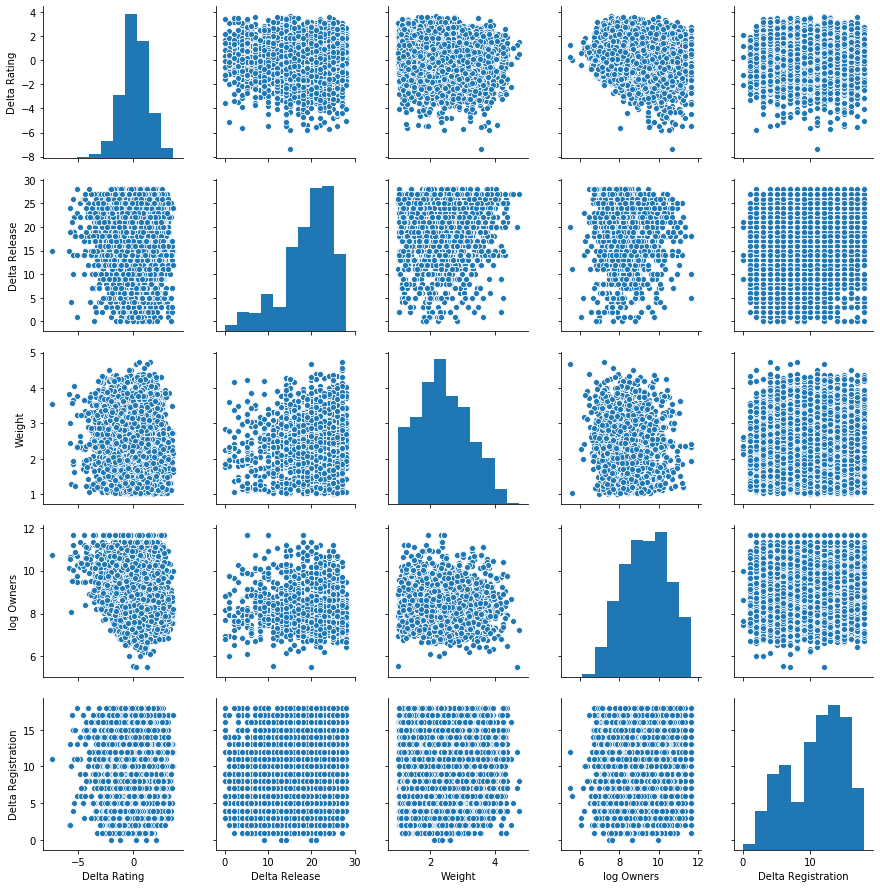

In [98]:
to_plot = bgg_1990[["Delta Rating", "Delta Release", "Weight", "log Owners", "Delta Registration"]]

sns.pairplot(to_plot)
plt.show()

Things look pretty good now - the variables are reasonably close to normally distributed. A simple ordinary least squares linear regression is appropriate here.

In [180]:
## fit an ols linear model for the relationship between delta rating and the other variables
# subset the full dataset
to_fit = bgg_1990[["Delta Release", "Weight", "log Owners", "Delta Registration"]]

# format the variables into arrays, add a constant for the intercept term
X = to_fit.as_matrix()
X = sm.add_constant(X)
Y = bgg_1990["Delta Rating"].as_matrix()

# fit the model, run t-tests on the coefficients
model = sm.OLS(Y, X).fit()
results = model.t_test(np.identity(X.shape[1]), use_t = True)

# output a coefficient summary
results.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
c0,1.1791,0.122,9.679,0.000,0.940,1.418
c1,-0.0040,0.002,-1.727,0.084,-0.009,0.001
c2,0.0070,0.017,0.416,0.677,-0.026,0.040
c3,-0.1265,0.011,-11.151,0.000,-0.149,-0.104
c4,0.0188,0.003,5.717,0.000,0.012,0.025


We did not find evidence that the release date and weight are significantly associated with user ratings.

The number of owners was found to be significantly associated, with a 1% increase in owners resulting in a decrease of 0.127 in user rating.

The registration date was also found to be significantly associated, with each year passed since 1990 resulting in an increase of 0.019 in user rating.

Finally, checking modeling assumptions.

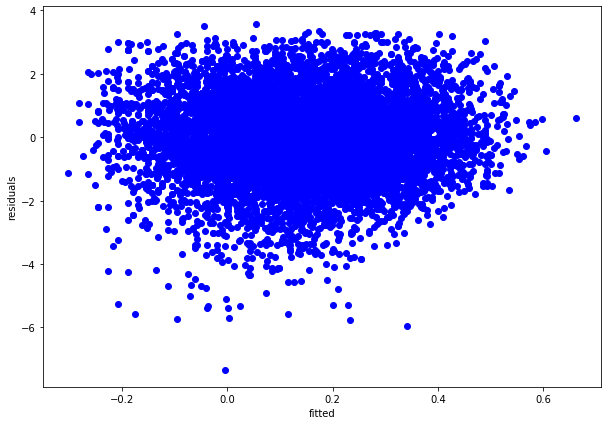

In [220]:
# plot residuals versus fitted values
plt.plot(model.fittedvalues, model.resid, 'bo')
plt.xlabel("fitted")
plt.ylabel("residuals")

plt.show()

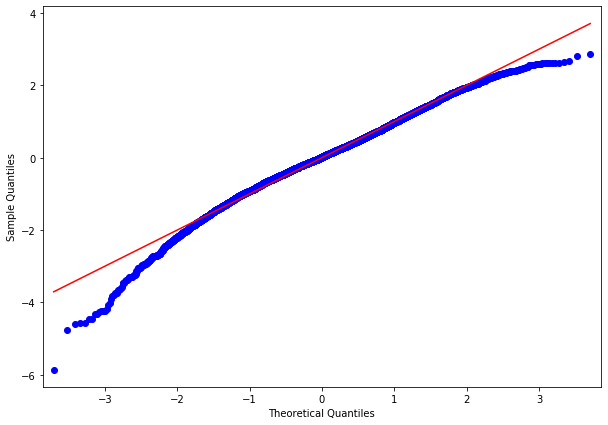

In [229]:
# Q-Q plot of standardized residuals
fig = ProbPlot(model.resid / np.std(model.resid, ddof = 1)).qqplot(line = "s")

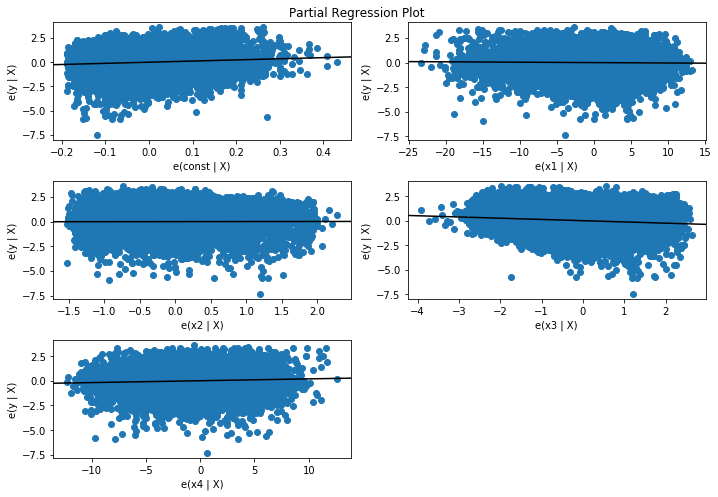

In [208]:
fig = sm.graphics.plot_partregress_grid(model)

In [184]:
## refit the model adding quadratic terms
# subset the full dataset
to_fit = bgg_1990[["Delta Release", "Weight", "log Owners", "Delta Registration"]]

# add quadratic terms
to_fit = pd.concat([to_fit, to_fit.apply(lambda x: x**2)], axis = 1)

# format the variables into arrays, add a constant for the intercept termX = to_fit.as_matrix()
X = to_fit.as_matrix()
X = sm.add_constant(X)
Y = bgg_1990["Delta Rating"].as_matrix()

# fit the model, run t-tests on the coefficients
model2 = sm.OLS(Y, X).fit()
results = model2.t_test(np.identity(X.shape[1]), use_t = True)

# output a coefficient summary
results.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
c0,4.7510,0.745,6.376,0.000,3.290,6.212
c1,-0.0030,0.010,-0.293,0.769,-0.023,0.017
c2,0.0609,0.097,0.628,0.530,-0.129,0.251
c3,-0.9174,0.158,-5.804,0.000,-1.227,-0.608
c4,0.0089,0.014,0.615,0.538,-0.019,0.037
c5,4.728e-06,0.000,0.016,0.988,-0.001,0.001
c6,-0.0098,0.019,-0.519,0.604,-0.047,0.027
c7,0.0425,0.008,5.015,0.000,0.026,0.059
c8,0.0005,0.001,0.698,0.485,-0.001,0.002


The relationship between log(Owners) and Rating appears to be non-linear. We will add in the quadratic term.

In [189]:
## refit the model adding log(Owners)^2
# subset the full dataset
to_fit = bgg_1990[["Delta Release", "Weight", "log Owners", "Delta Registration"]]

# add log(Owners)^2
to_fit = pd.concat([to_fit, to_fit["log Owners"].apply(lambda x: x**2)], axis = 1)

# format the variables into arrays, add a constant for the intercept termX = to_fit.as_matrix()
X = to_fit.as_matrix()
X = sm.add_constant(X)
Y = bgg_1990["Delta Rating"].as_matrix()

# fit the model, run t-tests on the coefficients
model3 = sm.OLS(Y, X).fit()
results = model3.t_test(np.identity(X.shape[1]), use_t = True)

# output a coefficient summary
results.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
c0,4.8011,0.724,6.631,0.000,3.382,6.220
c1,-0.0028,0.002,-1.229,0.219,-0.007,0.002
c2,0.0108,0.017,0.643,0.521,-0.022,0.044
c3,-0.9246,0.158,-5.864,0.000,-1.234,-0.616
c4,0.0187,0.003,5.704,0.000,0.012,0.025
c5,0.0429,0.008,5.075,0.000,0.026,0.059


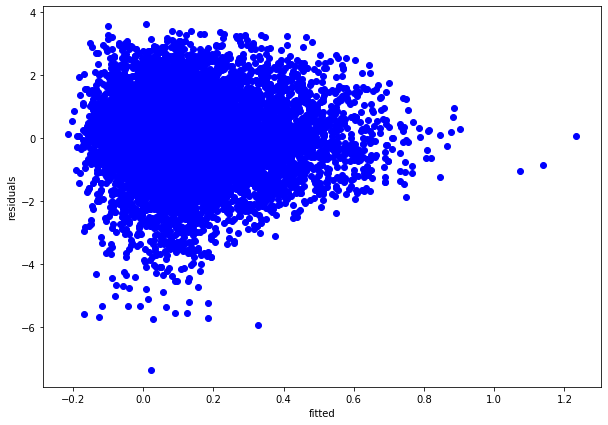

In [236]:
# plot residuals versus fitted values
plt.plot(model3.fittedvalues, model3.resid, 'bo')
plt.xlabel("fitted")
plt.ylabel("residuals")

plt.show()

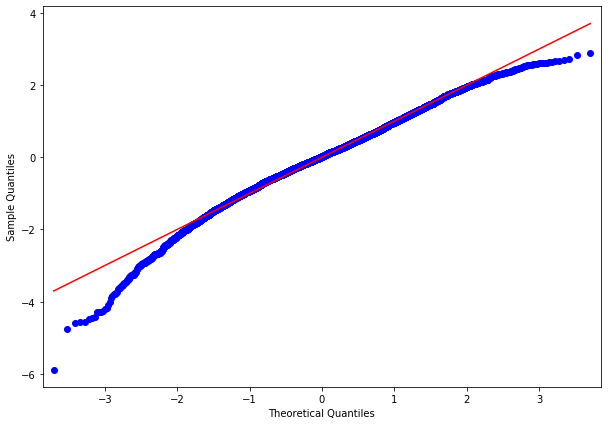

In [227]:
# Q-Q plot of standardized residuals
fig = ProbPlot(model3.resid/np.std(model3.resid, ddof = 1)).qqplot(line = "s")

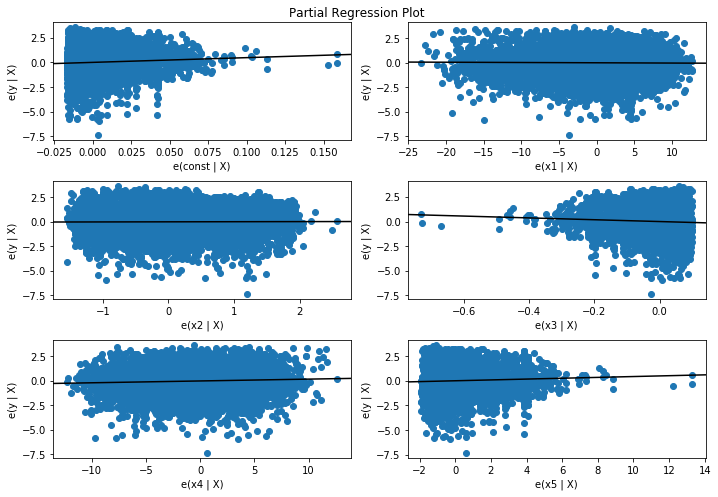

In [223]:
fig = sm.graphics.plot_partregress_grid(model3)

The distribution of residuals appears to be somewhat left skewed by a number of outliers. This is perhaps an artifact of the rating scale cutting off at 10? We will use robust regression as a means of decreasing these observations' effect on the coefficents without throwing them out entirely.

In [237]:
## refit the model using robust regression with a biweight weighting function
# subset the full dataset
to_fit = bgg_1990[["Delta Release", "Weight", "log Owners", "Delta Registration"]]

# add log(Owners)^2
to_fit = pd.concat([to_fit, to_fit["log Owners"].apply(lambda x: x**2)], axis = 1)

# format the variables into arrays, add a constant for the intercept termX = to_fit.as_matrix()
X = to_fit.as_matrix()
X = sm.add_constant(X)
Y = bgg_1990["Delta Rating"].as_matrix()

# fit the model, run t-tests on the coefficients
model_robust = sm.RLM(Y, X, M = sm.robust.norms.TukeyBiweight()).fit()
results = model_robust.t_test(np.identity(X.shape[1]), use_t = True)

# output a coefficient summary
results.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
c0,4.0733,0.708,5.752,0.000,2.685,5.462
c1,-0.0017,0.002,-0.764,0.445,-0.006,0.003
c2,0.0437,0.016,2.658,0.008,0.011,0.076
c3,-0.8109,0.154,-5.258,0.000,-1.113,-0.509
c4,0.0175,0.003,5.459,0.000,0.011,0.024
c5,0.0386,0.008,4.667,0.000,0.022,0.055
